#### Import required libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mtpl
import matplotlib.pyplot as plt
from csaps import csaps
import time
import math

font = {'family' : 'serif','weight' : 'ultralight','size'   : 14}
mtpl.rc('font', **font)

#### Define functions
Class Haar uses the second order Haar structure function to compute Haar fluctuations root mean square (RMS).

In [2]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    if m < 60:
        return '%dm %ds' % (m, s)
    else:
        h = math.floor(m/60)
        m -= h*60
        return '%dh %dm %ds' % (h, m, s)

class Haar:
    def __init__(self,t,x):
        self.t = np.array(t)
        self.x = np.array(x)

        self.deltas_t = []
        self.epsilons = []

        self.ep_min = None
        self.ep_max = None
        self.calib = None
        self.Hs = None

    def compute_deltas(self):
        for i in range(1,int(len(self.t)/2)+1):  
            self.deltas_t.append(self.t[i:]-self.t[:-i]) 

    def compute_epsilons(self):
        for i in range(1,len(self.deltas_t)+1):
            self.epsilons.append(self.deltas_t[i-1][:-i]/(self.deltas_t[i-1][:-i]+self.deltas_t[i-1][i:]))

    def fluctuations(self,ep_min=0.25,calib=2,verbose=True,prop_print=500):
        """
        Computing fluctuations

        Arguments:
            ep_min: float
                default 0.25

            calib: int
                default 2

            prop_print: int
                how often do we print the progress, default 500
        """
        self.x = self.x[:-1]
        self.t = self.t[:-1]
        self.ep_min = ep_min
        self.ep_max = 1 - self.ep_min
        self.calib = calib

        self.Hs = []
        self.delta_t = [] 
        counter = 0
        
        
        start_time = time.time()

        for H in range(2,len(self.x)-1,2):
            for start in range(len(self.x)-H-1):
                int1 = np.sum(self.x[start:start+int(H/2)]*self.deltas_t[0][start:start+int(H/2)]/self.deltas_t[int(H/2)-1][start])
                int2 = np.sum(self.x[start+int(H/2):start+H]*self.deltas_t[0][start+int(H/2):start+H]/self.deltas_t[int(H/2)-1][start+int(H/2)])
                counter += 1

                if self.epsilon_range(H,start):
                    self.Hs.append((calib*(int2 - int1))**2)  
                    self.delta_t.append(self.deltas_t[int(H/2)-1][start] + self.deltas_t[int(H/2)-1][start+int(H/2)])  
                
            if verbose:
                prop = 100*H / (len(self.x) - 1)
                if H % prop_print  == 0:
                    print("Progress: {}%, time elapsed {}".format('%.3f'%(prop),timeSince(start_time)))

        if verbose:
            print("Finished computations in {}".format(timeSince(start_time)))
            perct = (counter - len(self.Hs))/counter*100
            perct = '%.3f'%(perct)
            print("{} fluctuations removed ({}%)".format(counter - len(self.Hs),perct))
            
            
    def epsilon_range(self,H,start):
        min_condition = self.ep_min  < self.epsilons[int(H/2)-1][start]
        max_condition = self.epsilons[int(H/2)-1][start] < self.ep_max
        return min_condition and max_condition

    @property
    def data_df(self):
        if self.Hs is None:
            raise ValueError("Hs not yet defined")
        df = pd.DataFrame(data={'delta t':self.delta_t , 'Hs': self.Hs})
        return df.sort_values('delta t',axis=0).reset_index(drop=True)
    
    @property
    def csap(self):
        spiky_t=pd.DataFrame(np.log10(np.round(self.data_df['delta t'],3)), columns = ['delta t'])
        spiky_v=pd.DataFrame(self.data_df['Hs'],columns=['Hs'])
        spiky=pd.concat([spiky_t,spiky_v],axis=1)
        spiky=spiky.groupby("delta t", as_index=False).mean()
        spiky['Hs']=np.log10(np.sqrt(spiky['Hs']))
        spiky=spiky.replace([np.inf, -np.inf], np.nan).dropna()

        xi = np.linspace(min(spiky['delta t']), max(spiky['delta t']), len(spiky['delta t']))
        yi = csaps(spiky['delta t'],spiky['Hs'], xi, smooth=0.9999)
        return xi,yi

    

def Haar_RMS_fluctuations(t,x):
    H=Haar(t,x)
    H.compute_deltas()
    H.compute_epsilons()
    H.fluctuations()
    return H.csap[0],H.csap[1]
    

#### Import file
File: Non-uniformly sampled EDC 800ky B.P. Temperatures. We filter it roughly to the LGC (130ky B.P.).

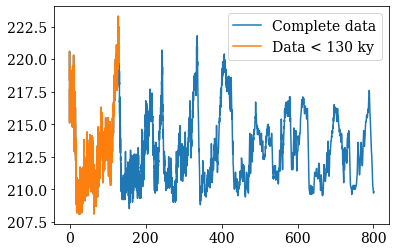

Samples:  3106


In [3]:
file='EDC_DeutTemp.xlsx'
df_data=pd.read_excel(file)

columns=df_data.size/len(df_data) 
data_list=[];new_length=np.array([])

for i in range(int(columns)):
    if (i+1)%2==1: 
        dupla=df_data[[df_data.columns[i],df_data.columns[i+1]]].dropna() 
        dupla.index=[j for j in range(0, len(dupla))] 
        data_list.append(dupla)
        new_length=np.append(new_length,np.shape(dupla)[0])

ix=0
age=data_list[ix][data_list[ix].columns[0]]
Value=data_list[ix][data_list[ix].columns[1]]

age_cut=age[age<130];Value_cut=Value[age<130]
plt.plot(age,Value,label='Complete data')
plt.plot(age_cut,Value_cut,label='Data < 130 ky')
plt.legend()
plt.show()

print('Samples: ',len(age_cut))

#### Run and visualization
Computes the Haar fluctuation RMS of EDC LGC temperatures. Results are visualized in log-log scale.

In [4]:
[time_scales,fluctuations]=Haar_RMS_fluctuations(age_cut,Value_cut)

Progress: 16.108%, time elapsed 0m 13s
Progress: 32.216%, time elapsed 0m 25s
Progress: 48.325%, time elapsed 0m 35s
Progress: 64.433%, time elapsed 0m 43s
Progress: 80.541%, time elapsed 0m 48s
Progress: 96.649%, time elapsed 0m 50s
Finished computations in 0m 50s
0 fluctuations removed (0.000%)


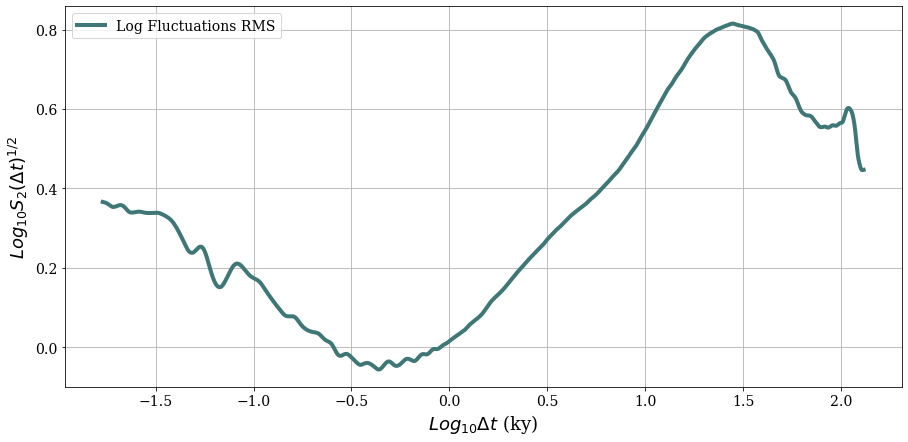

In [5]:
plt.subplots(figsize=(15, 7))
plt.plot(time_scales,fluctuations,color='#3f7776',linewidth=4,label='Log Fluctuations RMS')
plt.xlabel(r'$Log_{10}\Delta t$ (ky)',fontsize=18)
plt.ylabel(r'$Log_{10}S_2(\Delta t)^{1/2}$',fontsize=18)
plt.legend()
plt.grid()
plt.show()